### 機器學習百日馬拉松期中練習測驗
- 本賽題提供用戶在2016年1月1日至2016年5月31日之間真實線下消費行為，預測用戶在2016年6月領取優惠券後15天以內的使用情況。 

In [2]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [3]:
# 檢視資料欄位描述
column_desc_df = pd.read_csv('data/midterm/column_description.csv', encoding = 'big5')
for i in column_desc_df.index:
    print(column_desc_df.ix[i][0], column_desc_df.ix[i][1])

User_id 用戶 ID
Merchant_id 商家 ID
Coupon_id 優惠券 ID (null 代表無優惠券消費)
Discount_rate 優惠券折價：[0,1] 代表折扣率；x:y 代表滿 x 減 y 元
Distance 用戶經常活動地點離商家最近距離 (x * 500 公尺), 0 表示低於 500 公尺, 10 表示大於 5 公里。
Date_received 優惠券取得時間
Date 購買商品時間 (如果 Date is null & Coupon_id is not null, 則該紀錄為有優惠券但未使用; 若為 Date is not null & Coupon_id is null, 則為普通消費日期; 若 Date is not null & Coupon_id is not null, 則表示優惠券消費日期)


In [48]:
# 檢視訓練資料
train_df = pd.read_csv('data/midterm/train_offline.csv', encoding = 'big5')
print(train_df.dtypes)
train_df.sample(n = 10)

User_id            int64
Merchant_id        int64
Coupon_id        float64
Discount_rate     object
Distance         float64
Date_received    float64
Date             float64
dtype: object


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
164408,3473660,1569,5054.0,200:30,4.0,20160401.0,NaN
520259,1395031,2146,3478.0,100:10,0.0,20160124.0,NaN
714304,6769731,7422,NaN,NaN,10.0,NaN,20160426.0
78311,120513,1125,NaN,NaN,0.0,NaN,20160325.0
560053,6856369,7237,NaN,NaN,3.0,NaN,20160424.0
426706,6226832,8269,1539.0,20:1,0.0,20160430.0,20160506.0
1022198,4267938,2099,12034.0,100:10,0.0,20160207.0,NaN
345892,5262835,1169,NaN,NaN,0.0,NaN,20160131.0
1103013,5778515,4191,8148.0,50:10,0.0,20160324.0,NaN
208982,2495751,1169,10929.0,200:30,0.0,20160129.0,NaN


In [5]:
# 1到5月各月份的消費次數 (月份0者，代表無消費)
train_df['shopping_month'] = train_df[np.isnan(train_df['Date']) == False]['Date'].apply(lambda d : int(str(int(d))[4:6]))
train_df['shopping_month'].fillna(0, inplace = True)
train_df['shopping_month'] = train_df['shopping_month'].astype(int)
train_df[train_df['shopping_month'] > 0]['shopping_month'].plot.hist(bins=5)


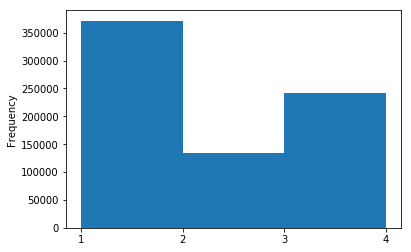

In [6]:
# 優惠券取得月份 (月份0者，代表無優惠券取得日期)
train_df['coupon_month'] = train_df[np.isnan(train_df['Date_received']) == False]['Date_received'].apply(lambda d : int(str(int(d))[4:6]))
train_df['coupon_month'].fillna(0, inplace = True)
train_df['coupon_month'] = train_df['coupon_month'].astype('int')

train_df[train_df['coupon_month'] > 0]['coupon_month'].plot.hist(bins=3, xticks = [1,2,3,4])

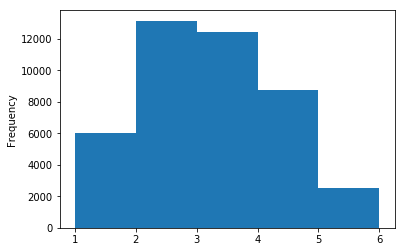

In [7]:
# 各月份使用優惠券消費的次數 (月份0者，代表無使用優惠券消費)
train_df['coupon_shoping_month'] = train_df[(np.isnan(train_df['Date']) == False) & (np.isnan(train_df['Coupon_id']) == False)]['Date'].apply(lambda d : int(str(int(d))[4:6]))
train_df['coupon_shoping_month'].fillna(0, inplace = True)
train_df['coupon_shoping_month'] = train_df['coupon_shoping_month'].astype('int')
train_df[train_df['coupon_shoping_month'] >0]['coupon_shoping_month'].plot.hist(bins=5)

In [20]:
# 優惠券取得日期屬於星期幾(1 Monday - 7 Sunday)
train_df['Date_received_day_of_week'] = train_df[~np.isnan(train_df['Date_received'])]['Date_received'].apply(lambda d : pd.to_datetime(d, format="%Y%m%d").weekday() + 1)
train_df['Date_received_day_of_week'].fillna(0, inplace = True)
train_df['Date_received_day_of_week'] = train_df['Date_received_day_of_week'].astype('int')

array([1, 2, 3, 4, 5, 6, 7])

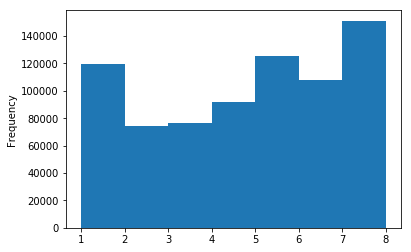

In [29]:
train_df['Date_received_day_of_week'] = train_df['Date_received_day_of_week'].astype('int')
train_df[train_df['Date_received_day_of_week'] >0]['Date_received_day_of_week'].plot.hist(bins=range(1, 9))
np.unique(train_df[train_df['Date_received_day_of_week'] >0]['Date_received_day_of_week'])

In [63]:
# 折扣率，原Discount_rate可能是小數(0.9)或比例(100:10 滿100減10,其實也等於九折)
def cnvt_discount_rate(rate_obj):
    rate_str = str(rate_obj)
    if rate_str == 'nan':
        return 1
    elif ':' in rate_str:
        _s = rate_str.split(':')
        return int(_s[1])/int(_s[0])
    else:
        return float(rate_str)

train_df['cnvt_discount_rate'] = train_df['Discount_rate'].apply(cnvt_discount_rate)
train_df['cnvt_discount_rate'].describe()

count    1.160742e+06
mean     4.726959e-01
std      4.147648e-01
min      1.000000e-02
25%      1.000000e-01
50%      1.666667e-01
75%      1.000000e+00
max      1.000000e+00
Name: cnvt_discount_rate, dtype: float64

In [ ]:
# 產生label
# Coupon_id 和 Date 有四種組合
# (0,0) -> 未消費也沒有優惠券、 (1,0) -> 未消費但有拿到優惠券、(0,1) -> 有消費但沒有優惠券、(1,1) -> 有消費並且有使用優惠券
# 我們要學習的是：拿到優惠券的人，會不會在15天內使用，所以還要考慮Date與Date_received的差距

# 1. 在所有資料中，只保留有拿優惠券者進行學習
# 2. Date is not NaN & (Date - Date_received <= 15) -> label=1 else label=0

In [130]:
# 檢視測試資料
test_df = pd.read_csv('data/midterm/test_offline.csv')
test_df

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,1439408,4663,11002.0,150:20,1.0,20160528.0
1,1439408,2632,8591.0,20:1,0.0,20160613.0
2,1439408,2632,NaN,NaN,0.0,NaN
3,1439408,2632,8591.0,20:1,0.0,20160516.0
4,2029232,450,1532.0,30:5,0.0,20160530.0
5,2029232,6459,12737.0,20:1,0.0,20160519.0
6,2029232,6459,NaN,NaN,0.0,NaN
7,2029232,6459,NaN,NaN,0.0,NaN
8,2747744,6901,1097.0,50:10,NaN,20160606.0
9,196342,1579,NaN,NaN,1.0,NaN
